# FINN - Folding
--------------------------------------
**Note: To run this notebook, you first need to run the build flow in the 3rd cybersecurity notebook as we utilize one of the intermediate models generated in that process in this notebook.** 

This notebook describes the use of FINN parallelization parameters (PE & SIMD) to efficiently streamline models so as to extract the maximum performance out of them.

We'll use the utility function `showInNetron()` to visualize and interact with our network in the Jupyter Notebook and `showSrc()` to show source code of FINN library calls.

In [1]:
from finn.util.visualization import showInNetron, showSrc

Note: The build_flow in the cybsec_mlp notebook comprises a transformation step `step_target_fps_parallelization` that automatically sets custom parallelization parameters needed to achieve a given `target_fps` by invoking the `SetFolding` transformation.

More details of the above step can be found here: https://github.com/Xilinx/finn/blob/main/src/finn/builder/build_dataflow_steps.py#L394

This notebook shows the manual version of this step and explains how these attributes can improve performance and what are their effects on resource utilization for developers who need to maximize the performance of their network. 

* input : the 'step_convert_to_hls.onnx' file (we pick has gone through a series of transformation passes) to be analyzed in terms of clock cycles and resource utilization per layer
* analyze the estimated execution clock cycles and the resource utilization of each layer in the network

### FINN-style Dataflow Architectures <a id='dataflow_arch'></a>

We start with a quick recap of FINN-style dataflow architectures. The key idea in such architectures is to parallelize across layers as well as within layers by dedicating a proportionate amount of compute resources to each layer, as illustrated in the figure below taken from the [FINN-R paper](https://arxiv.org/pdf/1809.04570.pdf):

![](finn-hw-arch.png)

In practice, the compute arrays are instantiated by function calls to optimized Vitis HLS building blocks from the [finn-hlslib](https://github.com/Xilinx/finn-hlslib) library. As these function calls can only handle certain patterns/cases, we need to transform the network into an appropriate form so that we can replace network layers with these function calls, which is the goal of the network preparation process.

# Part-1 : Loading the ONNX model.

The 'onnx' file needs to go through multiple transformations before it can be fed into our estimation functions.

The 'onnx' file loaded here is taken from the cybersecurity end2end example notebook. The build_step in the notebook comprises several series of transformations that take place before the onnx file is used for bitstream generation.
We pick the onnx file `step_convert_to_hls` to which the necessary transformations have been applied for this notebook (Network layers mapped to necessary FINN-HLS blocks. In this case, the `MatrixVectorActivation` Units). 

More information on these transformations can be found in the tfc_end2end_example notebook.

To interact with the 'onnx' file we use the `ModelWrapper()` helper function. This function gives access to different model attributes and allows us to apply custom tranformations to it.
In the below cell, we load our onnx file and view the cybersecurity MLP network in netron.

In [2]:
from qonnx.core.modelwrapper import ModelWrapper
model = ModelWrapper("./step_convert_to_hls.onnx")

showInNetron("./step_convert_to_hls.onnx",localhost_url='xirxlabs53')

Serving './step_convert_to_hls_folding.onnx' at http://0.0.0.0:5901


# Part 2 : Parallelisation Attributes : PE & SIMD

**PE & SIMD represent the amount of time-multiplexity to which we expose each of our network layers. 
These parallelization attributes are subject to certain constraints and should be selected accordingly.**

We see how they work through an example of a  multiplication computation (Matrix-Vector) in the `MatrixVectorActivation` layer looks like.

From the below block diagram, we observe that `SIMD` represents the parallelism within a single dot-product computation (the number of multiplications is a single clock cycle), while `PE` refers to how many such (Matrix-Vector?) dot-products execute in parallel.

If `PE` & `SIMD` are set to 2 & 4 for a given layer that means, that within a dot-product 4 multiplications will happen in parallel and 2 such dot-products will execute in parallel.

The base case of `PE` & `SIMD` both set as 1 suggest that there will be no parallelization therefore the resource utilization would be low (resources can be resued for differnt multiplication operations) when compared to settings where network layers have higher `PE` & `SIMD` values.

<div class="alert alert-block alert-warning">
<b>Question</b> in the third line of the above cell.
</div>

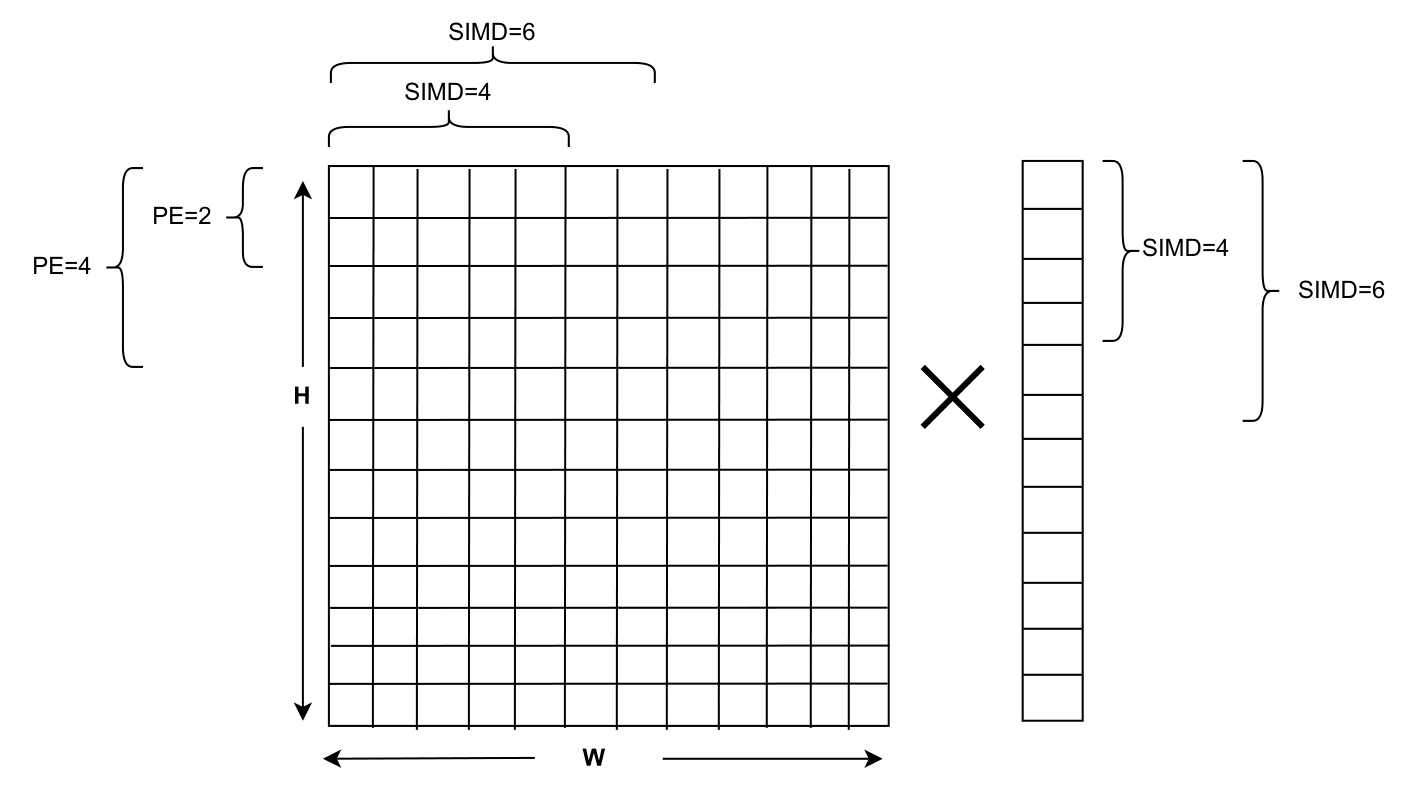

Based on the above block diagram we find that `PE` & `SIMD` parallelization attributes are subject to the following constraints. 
If `W` is the width of the input and `H` is the height of the output in a Matrix-Vector Computation then:

        W % SIMD == 0
        H % PE == 0
        
For the above example, H = 12 and W = 12. The demonstrated PE & SIMD values adhere to the above constraints.

We also define a term referred to as total folding which is defined as :

    Total folding = (H/PE) x (W/SIMD)

The goal of adjusting these parameters is to get an almost balanced pipeline i.e. equalling the rate of producers and consumers in the generated dataflow architecture.
This can be achieved (or almost achieved) by keeping the `total folding` parameter approximately constant across all layers.

We now explore how these parameters affect the estimated clock cycles and the resource utilization of the generated dataflow architectures.
We start with a naive case where `PE` & `SIMD` values across all layers are 1 and observe the above-mentioned numbers.
We define the utility functions  (`exp_cycles_per_layer()`) and  (`res_estimation()`) to estimate the number of clock cycles and resource utilization of each network layer.

<div class="alert alert-block alert-warning">
<b>Should this line be added</b> (The `exp_cycles_per_layer` formula is equal to the total folding in this case as the number of input vectors is 1 and the mmv value is also 1).
</div>

In [3]:
from finn.analysis.fpgadataflow.exp_cycles_per_layer import exp_cycles_per_layer
from finn.analysis.fpgadataflow.res_estimation import res_estimation

We now individually extract the `MatrixVectorActivation` blocks from the onnx file and set the config values manually (although this can be done automatically by Vivado tools also as mentioned in the introduction).

In the first step, we set the `PE` & `SIMD` values for all the layers to be '1' to establish a baseline and measure the estimated clock cycles and resource utilization for each of the individual layers.

We utilize from (`getCustomOp()`) as the helper function to set different properties of the node. The (`set_nodeattr()`) function within this function call helps us set these values.

In [4]:
from qonnx.custom_op.registry import getCustomOp
fc_layers = model.get_nodes_by_op_type("MatrixVectorActivation")
# (PE, SIMD, in_fifo_depth, out_fifo_depth, ramstyle) for each layer
config = [
    (1, 1, [16], [64], "block"),
    (1, 1, [64], [64], "auto"),#8,8
    (1, 1, [64], [64], "auto"),#8,8
    (1, 1, [64], [1], "distributed"),
]
for fcl, (pe, simd, ififo, ofifo, ramstyle) in zip(fc_layers, config):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepths", ififo)
    fcl_inst.set_nodeattr("outFIFODepths", ofifo)
    fcl_inst.set_nodeattr("ram_style", ramstyle)

After setting these parameters, we save the model and view it using `Netron`
. We can observe the values we set in the above step by clicking on any of the nodes and observing their properties.

In [10]:
model.save("./cybsec_PE_SIMD_not_modified.onnx")
showInNetron("./cybsec_PE_SIMD_not_modified.onnx",localhost_url='xirxlabs53')

Stopping http://0.0.0.0:5901
Serving './cybsec_PE_SIMD_not_modified.onnx' at http://0.0.0.0:5901


We pass our model to the `exp_cycles_per_layer()` and `res_estimation()` functions which iteratively go through all the layers in the graph and measure the expected execution clock cycles and resource utilization for each of them and return a dictionary with calculated values.

In [6]:
cycles_dict = []
cycles_dict = exp_cycles_per_layer(model)

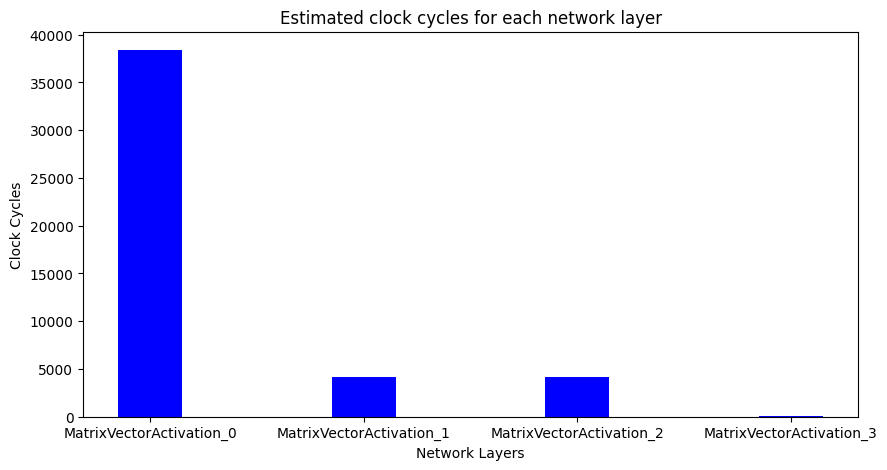

In [7]:
import matplotlib.pyplot as plt

layers = list(cycles_dict.keys())
cycles = list(cycles_dict.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(layers, cycles, color ='blue', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("Clock Cycles")
plt.title("Estimated clock cycles for each network layer")
plt.show()

In [8]:
res_dict = []
res_dict = res_estimation(model)

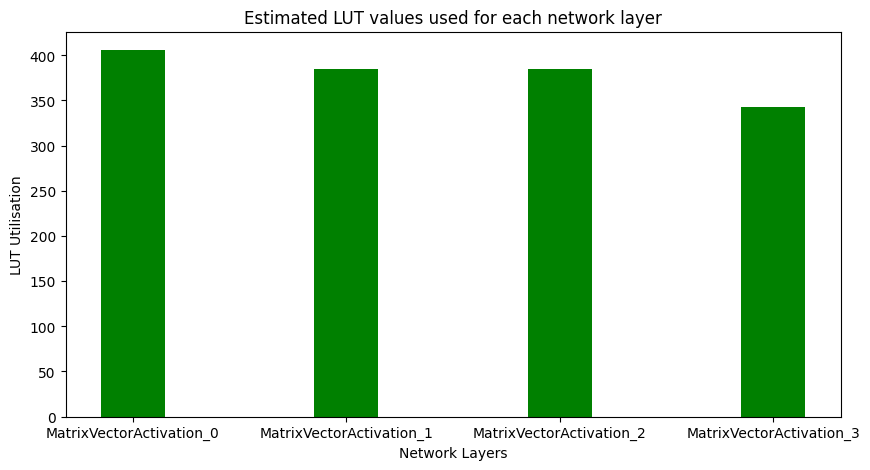

In [9]:
layers = list(res_dict.keys())
utilisation = list(res_dict.values())
lut_values = [] #Initializing a list to store LUT values.
for i in range(len(layers)):
    x = list(utilisation[i].values()) #Extracting the resource utilisation for each layer as a list.
    lut_values.append(x[2]) #Extracting the LUT values of resource utilisation from each layer and appending to the list
    
#Plotting the bar graph of each network layer with their corresponding LUT resource utilisation
fig = plt.figure(figsize = (10, 5))
plt.bar(layers, lut_values, color ='green', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("LUT Utilisation")
plt.title("Estimated LUT values used for each network layer")
plt.show()

Note, from the above result we observe that the bottleneck in the execution of the model on hardware would come from the execution of the first layer which takes estimated 38400 clock cycles to execute one set of its inputs.
No matter how quickly the layers execute the (throughput or latency?) will be defined by the first layer's execution latency.

So our goal to adjust the folding parameters would be to expand the computation of the first layer to reduce its latency at the expense an of increase in resource utilization.

<div class="alert alert-block alert-warning">
<b>Question</b> in the first line of the above cell.
</div>

# QuickNote : StreamingDataWidthConverter Layer

In [37]:
fc_layers = model.get_nodes_by_op_type("MatrixVectorActivation")
for fcl in fc_layers:
    fcl_inst = getCustomOp(fcl)
    print('Instream Width =',(fcl_inst.get_instream_width()),'Outstream Width =',int(fcl_inst.get_outstream_width()))

Instream Width = 1 Outstream Width = 2
Instream Width = 2 Outstream Width = 2
Instream Width = 2 Outstream Width = 2
Instream Width = 2 Outstream Width = 1


We can also view the `instream_width` and `outstream_width` of each layer using the `get_instream_width()` and `get_outstream_width()` helper functions. These widths are of particular importance as for a (balanced pipeline?) these width's should be the same.

For example, the outwidth of a given layer of the network should match the inwidth of the next layer for the (pipeline to be stable?). If they are not the same then the FINN compiler adds an extra `streamingdatawidthconverter` (which increases the overall resource utilization of the design slightly) layer to make sure these widths match.

Note, that if these widths are the same then even if we call the `InsertDWC()` transformation on our model (responsible for adding the above layer), the datawidth conversion layers will not be a part of our model as shown in the below cells. 

<div class="alert alert-block alert-warning">
<b>Question</b> in the first and the second line of the above cell.
</div>

In [11]:
from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
model = model.transform(InsertDWC())

In [12]:
model.save("./cybsec_DWC_not_inserted.onnx")
showInNetron("./cybsec_DWC_not_inserted.onnx",localhost_url='xirxlabs53')#localhost_url='xirxlabs60'

Stopping http://0.0.0.0:5901
Serving './cybsec_DWC_not_inserted.onnx' at http://0.0.0.0:5901


In [13]:
#To view the source code of the matrix vector activation function
from finn.custom_op.fpgadataflow.matrixvectoractivation import MatrixVectorActivation
showSrc(MatrixVectorActivation)

class MatrixVectorActivation(HLSCustomOp):
    """Class that corresponds to finn-hls Matrix_Vector_Activate(_Stream)_Batch
    function."""

    def __init__(self, onnx_node):
        super().__init__(onnx_node)
        self.decoupled_wrapper = templates.decoupled_wrapper

    def get_nodeattr_types(self):
        my_attrs = {
            "PE": ("i", True, 0),
            "SIMD": ("i", True, 0),
            "MW": ("i", True, 0),
            "MH": ("i", True, 0),
            "resType": ("s", False, "lut", {"auto", "lut", "dsp"}),
            "ActVal": ("i", False, 0),
            # FINN DataTypes for inputs, weights, outputs
            "inputDataType": ("s", True, ""),
            "weightDataType": ("s", True, ""),
            "outputDataType": ("s", True, ""),
            # FINN DataType for accumulator -- auto-computed and updated
            "accDataType": ("s", False, "INT32"),
            # use xnor-popcount for binary weights/inputs, thus treating them
            # as bipolar
  

## Modify Parameters

We now modify the parallelization attributes of the first network layer to reduce its overall latency.

In [14]:
fc_layers = model.get_nodes_by_op_type("MatrixVectorActivation") 
# (PE, SIMD, in_fifo_depth, out_fifo_depth, ramstyle) for each layer
config = [
    (2, 5, [16], [64], "block"),
    (1, 1, [64], [64], "auto"),#8,8
    (1, 1, [64], [64], "auto"),#8,8
    (1, 1, [64], [1], "distributed"),
]
for fcl, (pe, simd, ififo, ofifo, ramstyle) in zip(fc_layers, config):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepths", ififo)
    fcl_inst.set_nodeattr("outFIFODepths", ofifo)
    fcl_inst.set_nodeattr("ram_style", ramstyle)
    num_inp_vec = fcl_inst.get_nodeattr("numInputVectors")

We again save the model and view it. On expanding the first `MatrixVectorActivation` we can view the updated `PE` & `SIMD` parameters for that layer.

In [16]:
model.save("./cybsec_PE_SIMD_modified.onnx")
showInNetron("./cybsec_PE_SIMD_modified.onnx",localhost_url='xirxlabs53')

Stopping http://0.0.0.0:5901
Serving './cybsec_PE_SIMD_modified.onnx' at http://0.0.0.0:5901


From the above total folding formula, we have reduced the total folding of our layer from `600 x 64` to `120 x 32`. Hence, resulting in an estimated `10x` decrease in the execution latency of our layer. 
This can be observed in the new estimated clock cycles.

In [17]:
cycles_dict_updated = []
cycles_dict_updated = exp_cycles_per_layer(model)

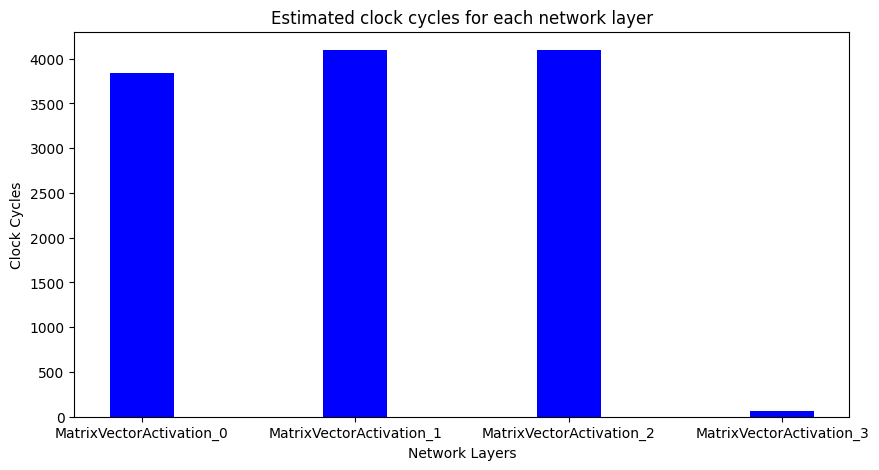

In [18]:
layers_updated = list(cycles_dict_updated.keys())
cycles_updated = list(cycles_dict_updated.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(layers_updated, cycles_updated, color ='blue', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("Clock Cycles")
plt.title("Estimated clock cycles for each network layer")
plt.show()

In [19]:
res_dict_updated = []
res_dict_updated = res_estimation(model)

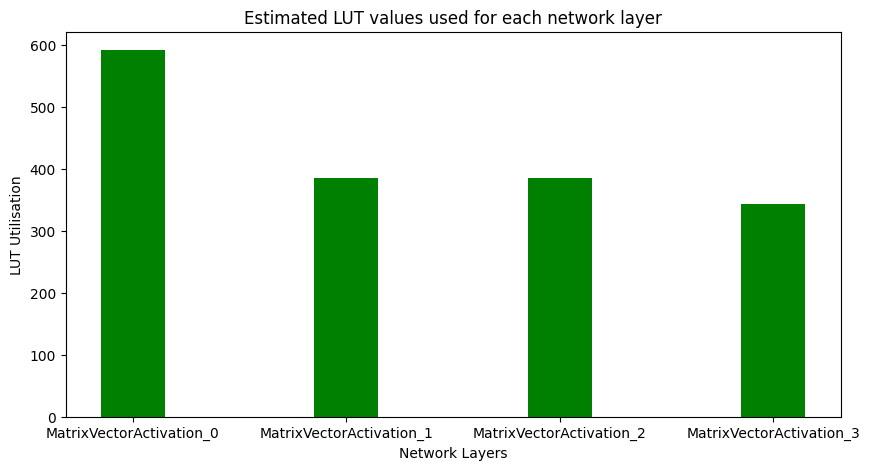

In [20]:
layers_updated = list(res_dict_updated.keys())
utilisation_updated = list(res_dict_updated.values())
lut_values_updated = [] #Initializing a list to store LUT values.
for i in range(len(layers_updated)):
    x = list(utilisation_updated[i].values()) #Extracting the resource utilisation for each layer.
    lut_values_updated.append(x[2]) #Extracting the LUT values of resource utilisation from each layer and appending to the list

#Plotting the bar graph of each network layer with their corresponding LUT resource utilisation
fig = plt.figure(figsize = (10, 5))
plt.bar(layers_updated, lut_values_updated, color ='green', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("LUT Utilisation")
plt.title("Estimated LUT values used for each network layer")
plt.show()

From these numbers, we see that the first layer has been removed as the bottleneck and that the entire network can now perform one inference in ~4096 clock cycles (when the pipeline is full) as compared to the earlier configuration where it took ~38400 execution cycles.

This decrease in execution latency of the network though comes at a cost of a 45% increase in LUT resource utilization for layer 1 of the network.

We now observe the `instream_width` and `outstream_width` of our network with the updated folding parameters and then apply the `InsertDWC()` transform to it in case there is a mismatch in these widths due to the updates. 

In [21]:
fc_layers = model.get_nodes_by_op_type("MatrixVectorActivation")
for fcl in fc_layers:
    fcl_inst = getCustomOp(fcl)
    print('Instream Width =',(fcl_inst.get_instream_width()),'Outstream Width =',int(fcl_inst.get_outstream_width()))

Instream Width = 5 Outstream Width = 4
Instream Width = 2 Outstream Width = 2
Instream Width = 2 Outstream Width = 2
Instream Width = 2 Outstream Width = 1


In [22]:
model = model.transform(InsertDWC())

In [24]:
model.save("./cybsec_DWC_inserted.onnx")
showInNetron("./cybsec_DWC_inserted.onnx",localhost_url='xirxlabs53')

Stopping http://0.0.0.0:5901
Serving './cybsec_DWC_inserted.onnx' at http://0.0.0.0:5901


Because there is a mismatch in the `outstream_width` (4) of layer 1 and the `inputstream_width` (2) of layer 2 the FINN compiler inserts the `StreamingDataWidthConverter` layer to remedy this when we call that transformation for our network above.

On expanding this layer in the netron we see that the `inWidth` of this layer is 4 and the `outWidth` is 2.

Note, we do not see this insertion where these widths match. They are only mismatched for the first two layers and hence we see that the data width converter is being inserted there.

In [25]:
res_dict_DWC = []
res_dict_DWC = res_estimation(model)

['MatrixVectorActivation_0', '', 'MatrixVectorActivation_1', 'MatrixVectorActivation_2', 'MatrixVectorActivation_3']


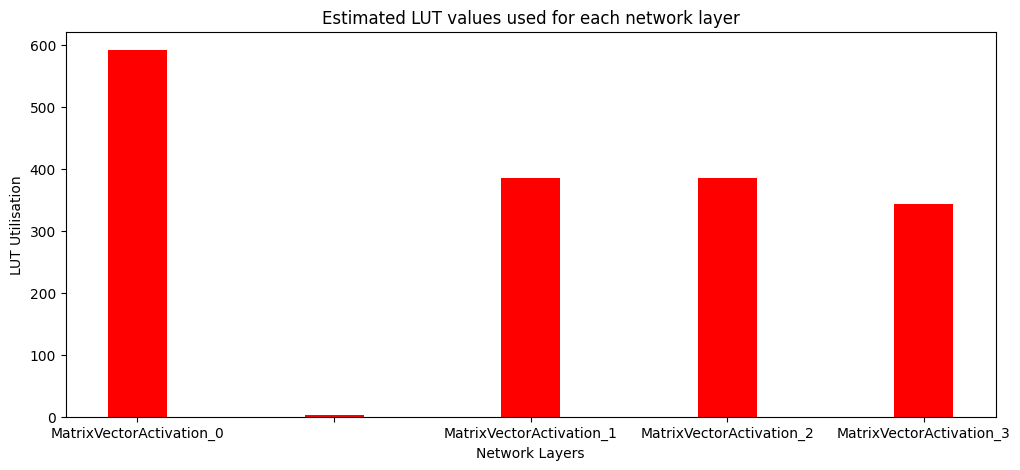

In [26]:
layers_DWC = list(res_dict_DWC.keys())
print(layers_DWC)
utilisation_DWC = list(res_dict_DWC.values())
lut_values_DWC = [] #Initializing a list to store LUT values.
for i in range(len(layers_DWC)):
    x = list(utilisation_DWC[i].values()) #Extracting the resource utilisation for each layer.
    lut_values_DWC.append(x[2]) #Extracting the LUT values of resource utilisation from each layer and appending to the list

#Plotting the bar graph of each network layer with their corresponding LUT resource utilisation
fig = plt.figure(figsize = (12, 5))
plt.bar(layers_DWC, lut_values_DWC, color ='red', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("LUT Utilisation")
plt.title("Estimated LUT values used for each network layer")
plt.show()

The `StreamingDataWidthConverter` layer does not consume a large number of LUT resources as shown in the above graph.

<div class="alert alert-block alert-warning">
<b>Question:</b> The name of the 'StreamingDataWidthConverter' layer is not coming in the graph.
</div>

# Additional Information : Constraints table

The below table exposes the constraints associated with each layer. A developer working with these layers has to be mindful of not violating them when setting the PE & SIMD values manually.

In [ ]:
+------------------------------------+------------+----------------------------------------------------------------+
| Layers                             | Attributes | Assertions                                                     |
+====================================+============+================================================================+
| addstreams_batch                   | PE         | inp_channels % PE == 0                                         |
| channelwise_op_batch               | PE         | channels % PE == 0                                             |
| checksum                           | ~          | ~                                                              |
| concat                             | ~          | ~                                                              |
| convolutioninputgenerator          | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| convolutioninputgenerator1d        | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| convolutioninputgenerator_rtl      | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| downsampler                        | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| duplicatestreams_batch             | PE         | channels % PE == 0                                             |
| eltwise                            | PE         | inp_channels % PE == 0                                         |
| fmpadding_batch                    | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| fmpadding_rtl                      | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| globalaccpool_batch                | PE         | channels % PE == 0                                             |
| hlscustomop                        | ~          | ~                                                              |
| iodma                              | ~          | ~                                                              |
| labelselect_batch                  | PE         | num_labels % PE == 0                                           |
| lookup                             | ~          | ~                                                              |
| matrixvectoractivation             | PE & SIMD  | matrix_height % PE == 0 & matrix_width % SIMD == 0             |
| pool_batch                         | PE         | input_feature_map_channels % PE == 0                           |
| streamingdataflowpartition         | ~          | ~                                                              |
| streamingdatawidthconverter_batch  | ~          | ~                                                              |
| streamingfifo                      | ~          | ~                                                              |
| streamingmaxpool_batch             | ~          | ~                                                              |
| templates                          | ~          | ~                                                              |
| thresholding_batch                 | PE         | matrix_height % PE == 0                                        |
| tlastmarker                        | ~          | ~                                                              |
| upsampler                          | ~          | ~                                                              |
| vectorvectoractivation             | PE & SIMD  | kernel_height * kernel_width % SIMD == 0 & channels % PE == 0  |
+------------------------------------+------------+----------------------------------------------------------------+